# EOSC 582 Assignment VII (Cloud classification)

In [1]:
__author__ = 'Yingkai (Kyle) Sha'
__email__  = 'yingkai@eos.ubc.ca'

In [2]:
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
from __future__ import division
from __future__ import print_function
from mpl_toolkits.basemap import Basemap
% matplotlib inline

# A View of the granule

The granule view from <a href='http://modis-atmos.gsfc.nasa.gov/IMAGES/'>**NASA MODIS Atmosphere Level-1B Granule Images**</a>. 
* Date: 2012-08-27.
* Filename: MOD\*.A2012240.0235.006.2012287184700.hdf.
* Binary (Fujiwhara) interaction between Typhoon Tembin (small) and Typhoon Bolaven (big).

<img src="_figures/240.0235.rgb143.jpg" width=700 align="left"/>

# Functions

2D-Histogram.

In [3]:
def plot_histogram(C1, C31, clevs, xy_bins=[150, 150]):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    # create bins for channel-31 
    C31_bins = xy_bins[0]
    C31_lim=[np.nanmin(C31), np.nanmax(C31)]
    C31_bins=np.linspace(C31_lim[0], C31_lim[1], C31_bins, dtype=np.float)
    # and channel-1
    C1_bins = xy_bins[1]
    C1_lim=[np.nanmin(C1), np.nanmax(C1)]
    C1_bins=np.linspace(C1_lim[0], C1_lim[1], C1_bins, dtype=np.float)

    y=C31.flat[:]; y_bins=C31_bins # x: C31
    x=C1.flat[:];  x_bins=C1_bins # y: C1
    H, y_edges, x_edges = np.histogram2d(y, x, bins=(y_bins, x_bins))
    X, Y = np.meshgrid(x_edges[:-1], y_edges[:-1])

    CMap=plt.cm.gist_ncar_r

    # set axis
    left=0.1; width = 0.8; bottom=0.1; height = 0.65
    gap=0.02; hist_len=0.2; cbar_len=0.12
    # three boxes
    rect_main  = [left+hist_len+gap, bottom, width, height]
    rect_histx = [left+hist_len+gap, left+height+gap, width-cbar_len, hist_len]
    rect_histy = [left, bottom, hist_len, height]
    # x, y limits
    xlim_bin=[np.min(X), np.max(X)]
    ylim_bin=[np.min(Y), np.max(Y)]
    # ========== figure ========== #
    fig=plt.figure(figsize=(9, 9))
    # ========== Main ========== #
    # axis
    axMain=plt.axes(rect_main) 
    axMain.yaxis.tick_right()
    axMain.yaxis.set_label_position('right')
    axMain.set_xlim(xlim_bin)
    axMain.set_ylim(ylim_bin)
    axMain.set_xlabel('Channel-1', fontsize=12)
    axMain.set_ylabel('Channel-31', fontsize=12)
    axMain.set_title('2-D Histogram', fontsize=16, fontweight='bold', x=1.15, y=1.15)
    divider=make_axes_locatable(axMain)
    # grid and frame
    axMain.grid() # grid on
    [i.set_linewidth(2) for i in axMain.spines.itervalues()] # a bold frame
    CS=axMain.contourf(X, Y, H, clevs, cmap=CMap, extend='both') # 2-D histgram
    CAx=divider.append_axes('right', size='5%', pad=0.75)
    CBar=plt.colorbar(CS, cax=CAx)
    CBar.set_label('Points', fontsize=10)
    CBar.ax.tick_params(axis='y', length=22.5)
    # ========== Hist-x ========== #
    axHistx=plt.axes(rect_histx)
    axHistx.hist(x, bins=x_bins, color=[1, 0.5, 1])
    axHistx.set_xlim(xlim_bin)
    axHistx.axes.get_xaxis().set_visible(False)
    # scientific notation for x, y-axis
    plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
    [i.set_linewidth(2) for i in axHistx.spines.itervalues()]
    axHistx.grid()
    # ========== Hist-y ========== #
    axHisty = plt.axes(rect_histy)
    axHisty.hist(y, bins=y_bins, color=[1, 0.5, 1], orientation='horizontal')
    axHisty.set_ylim(ylim_bin)
    axHisty.invert_xaxis()
    axHisty.axes.get_yaxis().set_visible(False)
    plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
    [i.set_linewidth(2) for i in axHisty.spines.itervalues()]
    axHisty.grid()

planckInvert

In [84]:
def planckInvert(wavel, Llambda):
    c=2.99792458e+08  #m/s -- speed of light in vacumn
    h=6.62606876e-34  #J s  -- Planck's constant
    kb=1.3806503e-23  # J/K  -- Boltzman's constant
    c1=2.*h*c**2.
    c2=h*c/kb
    Llambda=Llambda*1.e6  #convert to W/m^2/m/sr
    wavel=wavel*1.e-6  #convert wavelength to m
    Tbright=c2/(wavel*np.log(c1/(wavel**5.*Llambda) + 1.))
    return Tbright

# Read data

In [5]:
hdf_L1B=glob.glob('_data/EOSC 582 Cloud clustering/MOD021KM*.h5')
hdf_L2 =glob.glob('_data/EOSC 582 Cloud clustering/MOD06_L2*.h5')
hdf_GEO=glob.glob('_data/EOSC 582 Cloud clustering/MOD03*.h5')
L1B_obj=h5py.File(hdf_L1B[0], 'r')
L2_obj =h5py.File(hdf_L2[0] , 'r')
geo_obj=h5py.File(hdf_GEO[0], 'r')

##Geo coord.

In [6]:
lon_qkm=geo_obj['MODIS_Swath_Type_GEO']['Geolocation Fields']['Longitude'][:]
lat_qkm=geo_obj['MODIS_Swath_Type_GEO']['Geolocation Fields']['Latitude'][:]

## L1B
### Emissivity

In [42]:
raw_emiss=L1B_obj['MODIS_SWATH_Type_L1B/Data Fields/EV_1KM_Emissive'][:]
band_names=L1B_obj['MODIS_SWATH_Type_L1B/Data Fields/EV_1KM_Emissive'].attrs['band_names']
radiance_scales=L1B_obj['MODIS_SWATH_Type_L1B/Data Fields/EV_1KM_Emissive'].attrs['radiance_scales']
radiance_offsets=L1B_obj['MODIS_SWATH_Type_L1B/Data Fields/EV_1KM_Emissive'].attrs['radiance_offsets']
band_names=np.fromstring(band_names, dtype=np.float, sep=',')
radiance_scales=np.array(radiance_scales)
radiance_offsets=np.array(radiance_offsets)

In [43]:
# channel-31
hit=band_names==31
raw_C31=raw_emiss[hit, :, :]
C31=(raw_C31 - radiance_offsets[hit] * np.ones(raw_C31.shape)) * radiance_scales[hit]
# channel-29
hit=band_names==29
raw_C29=raw_emiss[hit, :, :]
C29=(raw_C29 - radiance_offsets[hit] * np.ones(raw_C29.shape)) * radiance_scales[hit]

### Aggr. 1km reflectance

In [9]:
raw_ARef=L1B_obj['MODIS_SWATH_Type_L1B/Data Fields/EV_250_Aggr1km_RefSB'][:]
band_names=L1B_obj['MODIS_SWATH_Type_L1B/Data Fields/EV_250_Aggr1km_RefSB'].attrs['band_names']
reflectance_scales=L1B_obj['MODIS_SWATH_Type_L1B/Data Fields/EV_250_Aggr1km_RefSB'].attrs['reflectance_scales']
reflectance_offsets=L1B_obj['MODIS_SWATH_Type_L1B/Data Fields/EV_250_Aggr1km_RefSB'].attrs['reflectance_offsets']
band_names=np.fromstring(band_names, dtype=np.float, sep=',')
reflectance_scales=np.array(reflectance_scales)
reflectance_offsets=np.array(reflectance_offsets)

In [10]:
# channel-1
hit=band_names==1
raw_C1=raw_ARef[hit, :, :]
C1=(raw_C1 - reflectance_offsets[hit] * np.ones(raw_C1.shape)) * reflectance_scales[hit]

## L2-06 cloud product

In [11]:
cloud_phase_raw=L2_obj['mod06/Data Fields/Cloud_Phase_Infrared_1km'][:]

# Histogram

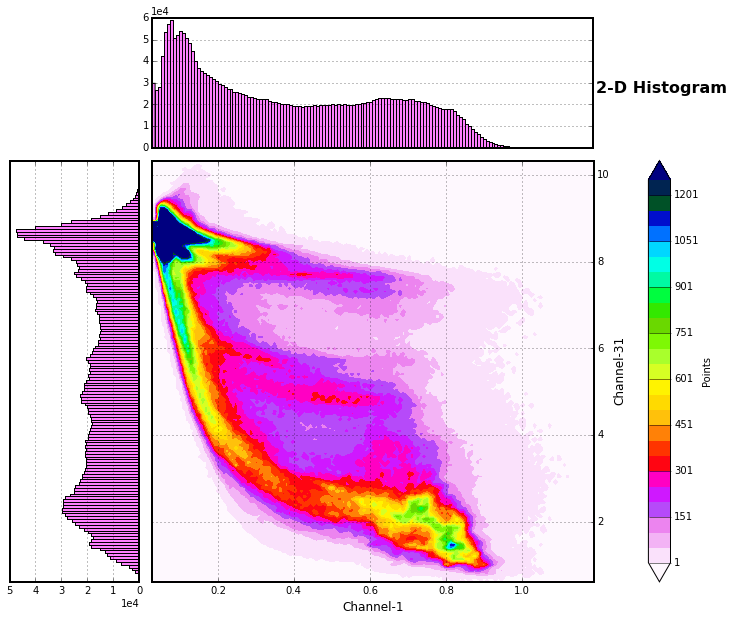

In [12]:
clevs=np.arange(1, 1250+50, 50)
plot_histogram(C1, C31, clevs, xy_bins=[150, 150])

#Cloud phase classification 

<a href='http://modis-atmos.gsfc.nasa.gov/_specs_c6/MOD06_L2_CDL_2013_03_28.txt'>**Information of MODIS L2 Cloud phase product**</a>:

<img src="_figures/MOD06_L2.PNG" width=950 align="left"/>

## Cloud phase plot

In [12]:
# change 6 to 3 for continuity
cloud_phase_raw[cloud_phase_raw==6]=3
# Cloud phase
PHASE=[ 'Cloud free' , \
        'Water cloud', \
        'Ice cloud'  , \
        'Undetermined phase' ] 

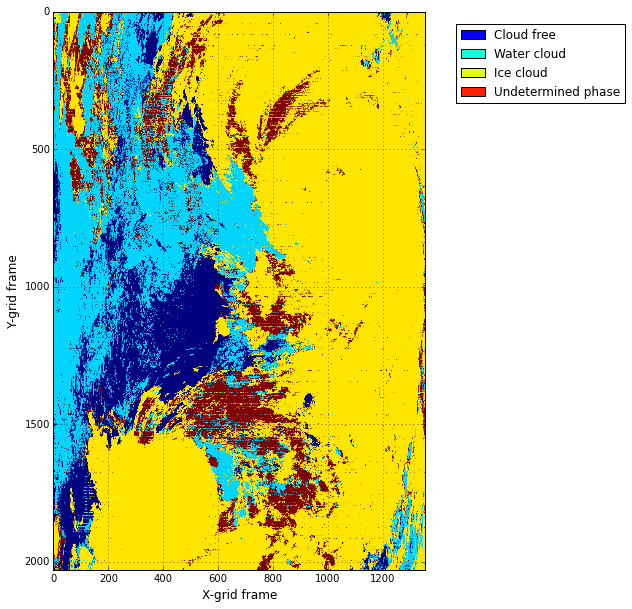

In [38]:
fig = plt.figure(figsize=(12, 10))
ax = fig.gca(); ax.grid()
CS = plt.contourf(cloud_phase_raw[::50, ::50], range(5))
ax.imshow(cloud_phase_raw, vmin=0, vmax=3)
proxy = [plt.Rectangle((0, 0), 1, 1, fc = pc.get_facecolor()[0]) for pc in CS.collections]
ax.legend(proxy, PHASE, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=1)
ax.set_xlabel('X-grid frame', fontsize=12); ax.set_ylabel('Y-grid frame', fontsize=12)

### C29-C31

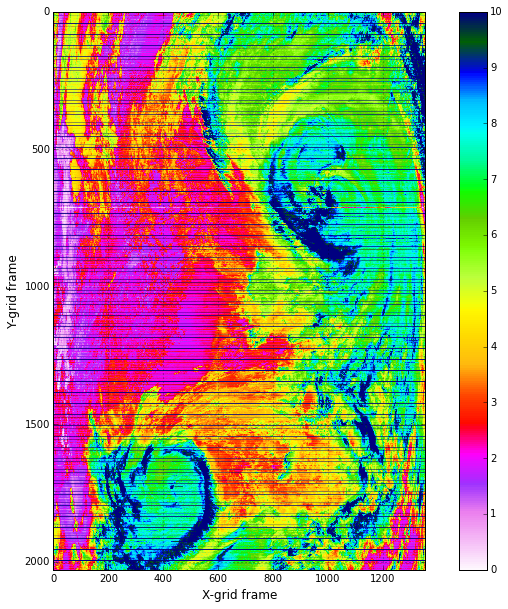

In [87]:
C31_TB = planckInvert(11.02, C31); C29_TB = planckInvert(8, C29)
fig = plt.figure(figsize=(12, 10))
ax = fig.gca(); ax.grid()
CS = ax.imshow(C29_TB[0, :, :] - C31_TB[0, :, :], vmin=0, vmax=10, cmap=plt.cm.gist_ncar_r)
fig.colorbar(CS); ax.set_xlabel('X-grid frame', fontsize=12); ax.set_ylabel('Y-grid frame', fontsize=12)

## Conclusion

* $T_{29} - T_{31}$ larger than 6 is a good criteria for 'ice cloud' 
* $T_{29} - T_{31}$ around 5 could be an 'undetermined phase'
* Low $T_{29} - T_{31}$ values are 'water cloud' or 'cloud free' 